In [1]:
import argparse
import json
import os
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from typing import Dict, Any

from lib import modeling

import lib.data.transforms2d as t2d
from lib.config import config
from lib.utils.intrinsics import adjust_intrinsic
from lib.structures import DepthMap

import lib.visualize as vis
from lib.visualize import io, utils
from lib.visualize.image import write_detection_image, write_depth
from lib.structures.frustum import compute_camera2frustum_transform

import matplotlib.pyplot as plt

import platform
print(platform.python_version_tuple())
print(type(platform.python_version_tuple()))

('3', '8', '10')
<class 'tuple'>


In [2]:
def configure_inference(opts):
    # load config
    config.OUTPUT_DIR = opts.output
    config.merge_from_file(opts.config_file)
    config.merge_from_list(opts.opts)
    # inference settings
    config.MODEL.FRUSTUM3D.IS_LEVEL_64 = False
    config.MODEL.FRUSTUM3D.IS_LEVEL_128 = False
    config.MODEL.FRUSTUM3D.IS_LEVEL_256 = False
    config.MODEL.FRUSTUM3D.FIX = True

def visualize_results(results: Dict[str, Any], output_path: os.PathLike) -> None:
    device = results["input"].device
    output_path = Path(output_path)
    output_path.mkdir(exist_ok=True, parents=True)

    # Visualize depth prediction
    depth_map: DepthMap = results["depth"]
    depth_map.to_pointcloud(output_path / "depth_prediction.ply")
    write_depth(depth_map, output_path / "depth_map.png")

    # Visualize 2D detections
    # write_detection_image(results["input"], results["instance"], output_path / "detection.png")

    # Visualize projection
    vis.write_pointcloud(results["projection"].C[:, 1:], None, output_path / "projection.ply")

    # Visualize 3D outputs
    dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
    min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
    truncation = config.MODEL.FRUSTUM3D.TRUNCATION
    iso_value = config.MODEL.FRUSTUM3D.ISO_VALUE

    geometry = results["frustum"]["geometry"]
    surface, _, _ = geometry.dense(dense_dimensions, min_coordinates, default_value=truncation)
    instances = results["panoptic"]["panoptic_instances"]
    semantics = results["panoptic"]["panoptic_semantics"]

    # Main outputs
    camera2frustum = compute_camera2frustum_transform(depth_map.intrinsic_matrix.cpu(), torch.tensor(results["input"].size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)


    # remove padding: original grid size: [256, 256, 256] -> [231, 174, 187]
    camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
    frustum2camera = torch.inverse(camera2frustum)
    print(frustum2camera)
    vis.write_distance_field(surface.squeeze(), None, output_path / "mesh_geometry.ply", transform=frustum2camera)
    vis.write_distance_field(surface.squeeze(), instances.squeeze(), output_path / "mesh_instances.ply", transform=frustum2camera)
    vis.write_distance_field(surface.squeeze(), semantics.squeeze(), output_path / "mesh_semantics.ply", transform=frustum2camera)

    with open(output_path / "semantic_classes.json", "w") as f:
        json.dump(results["panoptic"]["panoptic_semantic_mapping"], f, indent=4)

    # Visualize auxiliary outputs
    vis.write_pointcloud(geometry.C[:, 1:], None, output_path / "sparse_coordinates.ply")

    surface_mask = surface.squeeze() < iso_value
    points = surface_mask.squeeze().nonzero()
    point_semantics = semantics[surface_mask]
    point_instances = instances[surface_mask]

    vis.write_pointcloud(points, None, output_path / "points_geometry.ply")
    vis.write_semantic_pointcloud(points, point_semantics, output_path / "points_surface_semantics.ply")
    vis.write_semantic_pointcloud(points, point_instances, output_path / "points_surface_instances.ply")

In [3]:
input_path = "data/front3d-sample/rgb_0007.png"
config_file = "configs/front3d_sample.yaml"
model_path = "data/panoptic-front3d.pth"
output = "output/sample_0007/"
opts=None

config.OUTPUT_DIR = output
config.merge_from_file(config_file)
# config.merge_from_list(opts)
# inference settings
config.MODEL.FRUSTUM3D.IS_LEVEL_64 = False
config.MODEL.FRUSTUM3D.IS_LEVEL_128 = False
config.MODEL.FRUSTUM3D.IS_LEVEL_256 = False
config.MODEL.FRUSTUM3D.FIX = True
    
# Define model and load checkpoint.
device = torch.device("cuda:0")

print("Load model...")
model = modeling.PanopticReconstruction()
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint["model"])  # load model checkpoint
model = model.to(device)  # move to gpu
model.switch_test()
  


Load model...


Load input image...


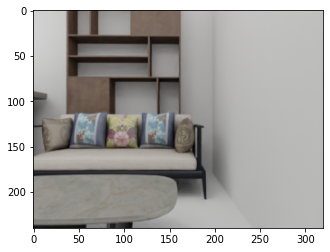

In [4]:
# Define image transformation.
color_image_size = (320, 240)
depth_image_size = (160, 120)

imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
image_transforms = t2d.Compose([
    t2d.Resize(color_image_size),
    t2d.ToTensor(),
    t2d.Normalize(imagenet_stats[0], imagenet_stats[1]),  # use imagenet stats to normalize image
])

# Open and prepare input image.
print("Load input image...")
input_image = Image.open(input_path)
input_image_orig = input_image.copy()
plt.imshow(input_image)
plt.show()

input_image = image_transforms(input_image)
input_image = input_image.unsqueeze(0).to(device)


In [5]:
# Prepare intrinsic matrix.
front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()

# Prepare frustum mask.
front3d_frustum_mask = np.load(str("data/frustum_mask.npz"))["mask"]
front3d_frustum_mask = torch.from_numpy(front3d_frustum_mask).bool().to(device).unsqueeze(0).unsqueeze(0)


In [6]:

print("Perform panoptic 3D scene reconstruction...")
with torch.no_grad():
    results = model.inference(input_image, front3d_intrinsic, front3d_frustum_mask)

print(f"Visualize results, save them at {config.OUTPUT_DIR}")
visualize_results(results, config.OUTPUT_DIR)

Perform panoptic 3D scene reconstruction...


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:159: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

Visualize results, save them at output/sample_0007/
tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


## Visualize generated 3D

<class 'lib.structures.depth_map.DepthMap'>
<class 'torch.Tensor'>
torch.Size([120, 160])
torch.Size([19200, 3])
(19200, 3)


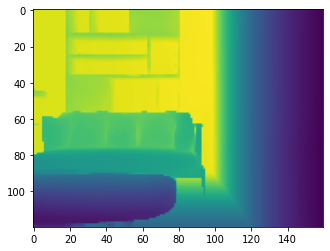

In [7]:
device = results["input"].device
depth_map: DepthMap = results["depth"]
depth_map_pcl, depthmap_coords2d = depth_map.compute_pointcloud()
depth_image = depth_map.depth_map.cpu().numpy()

# Depth Image and Pointcloud
print(type(depth_map))
print(type(depth_map.depth_map)) 
print(depth_map.depth_map.size())# Depth Image
print(depth_map_pcl.size()) # Point cloud
plt.imshow(depth_image)

depth_map_pcl_np = depth_map_pcl.cpu().numpy()
print(depth_map_pcl_np.shape)

## Get color for pcl

In [8]:
print(results["input"].size())


torch.Size([1, 3, 240, 320])


## Create Mesh in python3d

In [94]:
import os
import sys
import torch
import pytorch3d
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures

from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    TexturesUV,
    TexturesVertex
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
filename = 'output/sample_0007/mesh_instances.ply'
verts, faces = load_ply(filename)
verts_rgb_colors = torch.zeros([1, verts.shape[0], 3]).to(device)
print(verts_rgb_colors.shape)
tex = Textures(verts_rgb=verts_rgb_colors)
print(tex)
meshes = Meshes(verts=[verts], faces=[faces], textures=tex).to(device)

torch.Size([1, 51884, 3])


In [97]:
print(verts.shape[0])
print((meshes.faces_list()[0].shape))
print((meshes.textures))
print(verts)

51884
torch.Size([103908, 3])
tensor([[ 0.5263, -0.3564,  0.9250],
        [ 0.5325, -0.3586,  0.9250],
        [ 0.5325, -0.3564,  0.9228],
        ...,
        [-0.0975, -1.2564,  3.4461],
        [-0.0675, -1.2564,  3.4458],
        [-0.1275, -1.2264,  3.4451]])


In [111]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

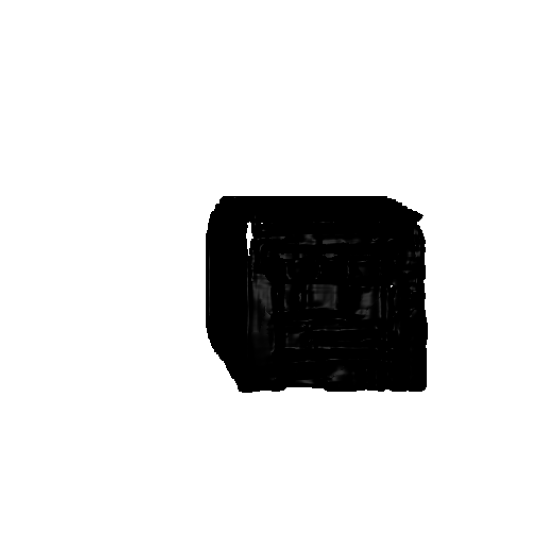

In [85]:
images = renderer(meshes)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## Obtain meshes for panoptic, semantic and geometry reconstruction

In [86]:
# Visualize projection

projection = results["projection"].C[:, 1:]

# Visualize 3D outputs
dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION
iso_value = config.MODEL.FRUSTUM3D.ISO_VALUE

geometry = results["frustum"]["geometry"]
surface, _, _ = geometry.dense(dense_dimensions, min_coordinates, default_value=truncation)
instances = results["panoptic"]["panoptic_instances"]
semantics = results["panoptic"]["panoptic_semantics"]
print(surface.shape)
print(instances.shape)
print(semantics.shape)


torch.Size([1, 1, 256, 256, 256])
torch.Size([256, 256, 256])
torch.Size([256, 256, 256])


/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  coords = coords // tensor_stride


In [87]:
# Main outputs
camera2frustum = compute_camera2frustum_transform(depth_map.intrinsic_matrix.cpu(), torch.tensor(results["input"].size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)

# remove padding: original grid size: [256, 256, 256] -> [231, 174, 187]
camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)
print(frustum2camera)

tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [112]:
# Meshes (SDF)
from typing import Union, Tuple, Optional
import marching_cubes as mc
from lib.utils.transform import coords_multiplication


def get_mesh(distance_field: np.array, iso_value: float = 1.0, truncation: float = 3.0) -> Tuple[np.array, np.array]:
    vertices, triangles = mc.marching_cubes(distance_field, iso_value, truncation)
    return vertices, triangles


def get_mesh_with_semantics(distance_field: np.array, labels: np.array, iso_value: float = 1.0, truncation: float = 3.0,
                            color_palette=None) -> Tuple[np.array, np.array, np.array]:
    labels = labels.astype(np.uint32)
    color_volume = utils.lookup_colors(labels, color_palette)
    vertices, colors, triangles = get_mesh_with_colors(distance_field, color_volume, iso_value, truncation)

    return vertices, colors, triangles

def get_mesh_with_colors(distance_field: np.array, colors: np.array, iso_value: float = 1.0,
                         truncation: float = 3.0) -> Tuple[np.array, np.array, np.array]:
    vertices, triangles = mc.marching_cubes_color(distance_field, colors, iso_value, truncation)
    colors = vertices[..., 3:]
    vertices = vertices[..., :3]

    return vertices, colors, triangles

def write_distance_field2(distance_field: Union[np.array, torch.Tensor], labels: Optional[Union[np.array, torch.Tensor]], iso_value: float = 1.0, truncation: float = 3.0,
                         color_palette=None, transform=None) -> None:
    if isinstance(distance_field, torch.Tensor):
        distance_field = distance_field.detach().cpu().numpy()

    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    if labels is not None:
        vertices, colors, triangles = get_mesh_with_semantics(distance_field, labels, iso_value, truncation,
                                                              color_palette)
    else:
        vertices, triangles = get_mesh(distance_field, iso_value, truncation)
        colors = None

    if transform is not None:
        if isinstance(transform, torch.Tensor):
            transform = transform.detach().cpu().numpy()

        vertices = coords_multiplication(transform, vertices)
    return vertices, colors, triangles
    # io.write_ply(vertices, colors, triangles, output_file)
    

vertices, colors, triangles = write_distance_field2(surface.squeeze(), None, transform=frustum2camera)
vertices_i, colors_i, triangles_i = write_distance_field2(surface.squeeze(), instances.squeeze(), transform=frustum2camera)
vertices_s, colors_s, triangles_s = write_distance_field2(surface.squeeze(), semantics.squeeze(), transform=frustum2camera)
print("SHAPES: vertices:{}, colors:{}, triangles: {}".format(vertices.shape, 0, triangles.shape))
print("SHAPES instance: vertices:{}, colors:{}, triangles: {}".format(vertices_i.shape, colors_i.shape, triangles_i.shape))
print("SHAPES semantic: vertices:{}, colors:{}, triangles: {}".format(vertices_s.shape, colors_s.shape, triangles_s.shape))

SHAPES: vertices:(51884, 3), colors:0, triangles: (103908, 3)
SHAPES instance: vertices:(51884, 3), colors:(51884, 3), triangles: (103908, 3)
SHAPES semantic: vertices:(51884, 3), colors:(51884, 3), triangles: (103908, 3)


In [134]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
filename = 'output/sample_0007/mesh_instances.ply'
verts, faces = load_ply(filename)
# colors = torch.ones([1, verts.shape[0], 3]).to(device)




colors = (torch.from_numpy(np.array([colors_i])).to(device)/255.0).type(torch.FloatTensor)
print(colors.shape)
print(colors)

# print(vertices_i)
# print(triangles_i)

tex = Textures(verts_rgb=colors)
meshes = Meshes(verts=[verts], faces=[faces], textures=tex).to(device)


torch.Size([1, 51884, 3])
tensor([[[0.6824, 0.7804, 0.9098],
         [0.6824, 0.7804, 0.9098],
         [0.6824, 0.7804, 0.9098],
         ...,
         [0.7373, 0.7412, 0.1333],
         [0.6824, 0.7804, 0.9098],
         [0.7373, 0.7412, 0.1333]]])


In [135]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

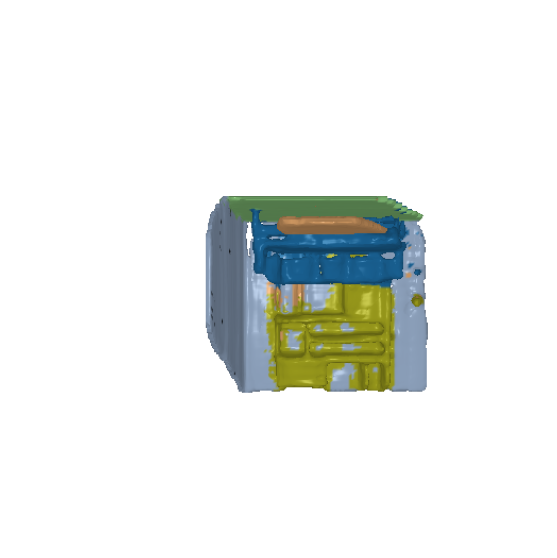

In [136]:
images = renderer(meshes)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## Visualize 3D Pointcloud using k3d

In [9]:
# Visualize 3D Geometry
import k3d
import numpy as np
colors = np.random.randint(0xff,0xff0000,size=19200)
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.points(depth_map_pcl_np, colors,point_size=0.05, shader="flat")
plot += plt_points
plot.display()

/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

## Panoptic Segmentation

In [90]:
instances = results["panoptic"]["panoptic_instances"]
semantics = results["panoptic"]["panoptic_semantics"]
camera2frustum = compute_camera2frustum_transform(depth_map.intrinsic_matrix.cpu(), torch.tensor(results["input"].size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)
print(results["input"].size())
print(instances.shape)
print(semantics.shape)
print(camera2frustum)

torch.Size([1, 3, 240, 320])
torch.Size([256, 256, 256])
torch.Size([256, 256, 256])
tensor([[ 33.3333,   0.0000,   0.0000, 114.7484],
        [  0.0000,  33.3333,   0.0000,  85.8808],
        [  0.0000,   0.0000,  33.3333, -13.3333],
        [  0.0000,   0.0000,   0.0000,   1.0000]])
